In [2]:
# nltk monkey patch
import sys 
import nltk
sys.modules["regex"] = __import__("re")
nltk.data.path.append(".")
# nltk.download("punkt", download_dir=".")
# nltk.download("averaged_perceptron_tagger", download_dir=".")

from datetime import datetime
from collections import Counter
from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xlrd
import csv

# makes dictionary from csv/txt
def webster(file, type=1):
    if type == 1:
        dic = dict(csv.reader(open(file, 'r')))
    else:
        dic = dict([line.split() for line in open(file).read().replace('\t', ' ').split('\n') if len(line) != 0])
    for key in dic:
        dic[key] = float(dic[key])
    return dic

# subsection - dictionaries
valence = webster('valence.csv', type=1)
arousal = webster('arousal.csv', type=1)
dominance = webster('dominance.csv', type=1)
anger = webster('anger-scores.txt', type=0)
sadness = webster('sadness-scores.txt', type=0)
anticipation = webster('anticipation-scores.txt', type=0)
disgust = webster('disgust-scores.txt', type=0)
fear = webster('fear-scores.txt', type=0)
joy = webster('joy-scores.txt', type=0)
surprise = webster('surprise-scores.txt', type=0)
trust = webster('trust-scores.txt', type=0)
humor = pd.read_csv('humor_dataset.csv')
humor_tot = dict(zip(humor['word'], humor['mean']))
humor_M = dict(zip(humor['word'], humor['mean_M']))
humor_F = dict(zip(humor['word'], humor['mean_F']))
humor_young = dict(zip(humor['word'], humor['mean_young']))
humor_old = dict(zip(humor['word'], humor['mean_old']))
selfish = ['I’m', "i'll", 'i’ll', 'me', 'I’ll', 'i’d', "i'd", 'my', 'myself', 'i’m', "i'm", 'i’ve', "i've", 'I', 'i’d’ve', "i'd've", 'i', 'mine']

# create local / global averages
def emoav(emo, selfemo, wrdct):
    emo_len = len(selfemo)
    perc_emo = emo_len / wrdct
    scores = [emo[word] for word in selfemo]
    if len(scores) == 0:
      return 0, 0
    else:
      avg_loc = np.mean(scores)
      avg_glo = avg_loc * perc_emo
      return avg_loc, avg_glo

# opens text file from excel
def bouncer(file):
    workbook = xlrd.open_workbook(file, on_demand=True)
    worksheet = workbook.sheet_by_index(0)
    first_row = [worksheet.cell_value(0,col) for col in range(worksheet.ncols)]

    data = []
    for row in range(1, worksheet.nrows):
        elm = {}
        for col in range(worksheet.ncols):
            elm[first_row[col]]=worksheet.cell_value(row,col)
        data.append(elm)
    return data

# feeds opened file into class
def hostess(data):
    return [Stripper(data[i]['text'], data[i]['index'], data[i]['date'], data[i]['time'], data[i]['person'], data[i]['diagnosis'], data[i]['age'], data[i]['gender']) for i in range(len(data))]

class Stripper:
    """For getting basic info from a file"""
    def __init__(self, text, index, date, time, person, diagnosis, age, gender):
        # imported info from excel
        self.stripped = text
        self.index = index
        self.date = datetime.strptime(date, '%d/%m/%y')
        self.time = time
        self.person = person
        self.diagnosis = diagnosis       
        self.age = age
        self.gender = gender       

        # top-line features
        self.sents = nltk.tokenize.sent_tokenize(self.stripped)
        self.pos_sents = [nltk.pos_tag(self.sents[i].split(' ')) for i in range(len(self.sents))]
        self.num_sents = len(self.sents)
        self.words_tok = nltk.tokenize.word_tokenize(self.stripped)
        self.words_raw = [x for x in self.stripped.split(' ')]
        self.wordcount = len(self.words_raw)
        self.clean_words = [word.lower().replace('.', '').replace(',', '') for word in self.words_raw]
        self.diff_words = set(self.clean_words)
        
        # POS features
        self.pos = nltk.pos_tag(self.words_tok)
        self.counts = Counter(tag for word,tag in self.pos)
        r = 0
        for key in self.counts:
            r += self.counts[key]
        r = r - (self.counts[','] + self.counts['.'])
        # all individual counts are relative to *pos counts* (not wordcounts)
        self.noun = 100 * (self.counts['NN'] + self.counts['NNS'] + self.counts['NNP'] + self.counts['NNPS']) / r
        self.pron = 100 * (self.counts['PRP'] + self.counts['PRP$']) / r
        self.adj = 100 * (self.counts['JJ'] + self.counts['JJR'] + self.counts['JJS']) / r
        self.adv = 100 * (self.counts['RB'] + self.counts['RBR'] + self.counts['RBS']) / r
        self.intj = 100 * (self.counts['UH']) / r
        self.verb = 100 * (self.counts['VB'] + self.counts['VBD'] + self.counts['VBG'] + self.counts['VBN'] + self.counts['VBP'] + self.counts['VBZ']) / r
        self.wh = 100 * (self.counts['WDT'] + self.counts['WP'] + self.counts['WP$'] + self.counts['WRB']) / r
        self.conj = 100 * (self.counts['CC']) / r
        self.prep = 100 * (self.counts['IN'] + self.counts['TO']) / r
        
        # fragments
        self.frag = 0
        self.sent_counts = [Counter(tag for word, tag in sent) for sent in self.pos_sents]
        verbs = {'VB','VBD','VBG','VBN','VBP','VBZ'}
        for sent in self.sent_counts:
            if len(verbs-set(sent.keys())) == len(verbs):
                self.frag += 1
                
        # word frequencies
        self.freq = nltk.FreqDist(word for word in self.clean_words)
        func = open('funcwords.txt').read().translate(str.maketrans("',[]", '    ')).split()
        self.funcs_freq = 100 * sum(self.freq[word] for word in self.freq if word in func) / self.wordcount
        self.rare = [word for word in self.freq if self.freq[word] == 1]
        self.rare_nonfunc = [word for word in self.rare if word not in func]
        self.selfish = sum(self.freq[word] for word in self.freq if word in selfish) / self.num_sents
        
        self.anger = [word for word in self.clean_words if word in anger.keys()]
        self.sadness = [word for word in self.clean_words if word in sadness.keys()]
        self.anticipation = [word for word in self.clean_words if word in anticipation.keys()]
        self.disgust = [word for word in self.clean_words if word in disgust.keys()]
        self.fear = [word for word in self.clean_words if word in fear.keys()]
        self.joy = [word for word in self.clean_words if word in joy.keys()]
        self.surprise = [word for word in self.clean_words if word in surprise.keys()]
        self.trust = [word for word in self.clean_words if word in trust.keys()]
        
        self.valence = [word for word in self.clean_words if word in valence.keys()]
        self.arousal = [word for word in self.clean_words if word in arousal.keys()]
        self.dominance = [word for word in self.clean_words if word in dominance.keys()]

        self.humor = [word for word in self.clean_words if word in humor_tot.keys()]
        
        # emotional strength
        self.al_fear, self.ag_fear = emoav(fear, self.fear, self.wordcount)
        self.al_joy, self.ag_joy = emoav(joy, self.joy, self.wordcount)
        self.al_trust, self.ag_trust = emoav(trust, self.trust, self.wordcount)
        self.al_surprise, self.ag_surprise = emoav(surprise, self.surprise, self.wordcount)
        self.al_disgust, self.ag_disgust = emoav(disgust, self.disgust, self.wordcount)
        self.al_anticipation, self.ag_anticipation = emoav(anticipation, self.anticipation, self.wordcount)
        self.al_anger, self.ag_anger = emoav(anger, self.anger, self.wordcount)
        self.al_sadness, self.ag_sadness = emoav(sadness, self.sadness, self.wordcount)

        self.al_valence, self.ag_valence = emoav(valence, self.valence, self.wordcount)
        self.al_arousal, self.ag_arousal = emoav(arousal, self.arousal, self.wordcount)
        self.al_dominance, self.ag_dominance = emoav(dominance, self.dominance, self.wordcount)

        self.al_humor_tot, self.ag_humor_tot = emoav(humor_tot, self.humor, self.wordcount)
        self.al_humor_M, self.ag_humor_M = emoav(humor_M, self.humor, self.wordcount)
        self.al_humor_F, self.ag_humor_F = emoav(humor_F, self.humor, self.wordcount)
        self.al_humor_young, self.ag_humor_young = emoav(humor_young, self.humor, self.wordcount)
        self.al_humor_old, self.ag_humor_old = emoav(humor_old, self.humor, self.wordcount)

        # sentence and word size
        self.short_sent, self.long_sent = 0, 0
        for sent in self.sents:
            if len(sent.split(' ')) <= 6:
                self.short_sent += 1
            else:
                self.long_sent += 1

        self.short_word, self.long_word = 0, 0
        for word in self.clean_words:
            if len(word) <= 6:
                self.short_word += 1
            else:
                self.long_word += 1
    
    # either gives brief description or returns numpy array
    def bare(self):
        return np.array([self.index, self.person, self.diagnosis, self.age, self.gender, self.time, self.num_sents, self.wordcount, self.noun, self.verb, self.adj, self.adv, self.intj, self.pron, self.wh, self.conj, self.prep, self.short_sent, self.long_sent, self.short_word, self.long_word, self.frag, len(self.diff_words), self.funcs_freq, self.selfish, len(self.rare), (100*len(self.rare_nonfunc)/self.wordcount), (100*len(self.joy)/self.wordcount), (100*len(self.surprise)/self.wordcount), (100*len(self.anticipation)/self.wordcount), (100*len(self.anger)/self.wordcount), (100*len(self.fear)/self.wordcount), (100*len(self.trust)/self.wordcount), (100*len(self.disgust)/self.wordcount), (100*len(self.sadness)/self.wordcount), self.al_fear, self.ag_fear, self.al_joy, self.ag_joy, self.al_trust, self.ag_trust, self.al_surprise, self.ag_surprise, self.al_disgust, self.ag_disgust, self.al_anticipation, self.ag_anticipation, self.al_anger, self.ag_anger, self.al_sadness, self.ag_sadness, self.al_valence, self.ag_valence, self.al_arousal, self.ag_arousal, self.al_dominance, self.ag_dominance, self.al_humor_tot, self.ag_humor_tot, self.al_humor_M, self.ag_humor_M, self.al_humor_F, self.ag_humor_F, self.al_humor_young, self.ag_humor_young, self.al_humor_old, self.ag_humor_old, (100*len(self.humor)/self.wordcount), (100*len(self.valence)/self.wordcount)])
        
# converts arrays into dataframe        
def cashout(arrays):
    temp = [[arrays[i].bare()] for i in range(len(arrays))]
    return pd.DataFrame(np.concatenate(temp), columns=['index', 'person', 'diagnosis', 'age', 'gender', 'time','sents','wordcount','noun','verb','adj','adv','intj','pron','wh','conj','prep','short sent','long sent','short word','long word','frag','# diff','% func words', 'selfish', '# unique', '% unique no func', '% joy', '% surprise', '% anticipation', '% anger', '% fear', '% trust', '% disgust', '% sadness', 'loc fear', 'glb fear', 'loc joy', 'glb joy', 'loc trust', 'glb trust', 'loc surprise', 'glb surprise', 'loc disgust', 'glb disgust', 'loc anticipation', 'glb anticipation', 'loc anger', 'glb anger', 'loc sadness', 'glb sadness', 'loc valence', 'glb valence', 'loc arousal', 'glb arousal', 'loc dominance', 'glb dominance', 'loc humor', 'glb humor', 'loc humor M', 'glb humor M', 'loc humor F', 'glb humor F', 'loc humor young', 'glb humor young', 'loc humor old', 'glb humor old', '% humor', '% VAD'])

# calculates composite measures into the dataframe
def dance(ndf):
    ndf['short/long'] = ndf['short sent'] / ndf['long sent']
    ndf['frag/min'] = ndf['frag'] / ndf['time'] * 60
    ndf['words/min'] = ndf['wordcount'] / ndf['time'] * 60
    ndf['sents/min'] = ndf['sents'] / ndf['time'] * 60
    ndf['words/sent'] = ndf['wordcount'] / ndf['sents']
    ndf['conj/sent'] = ndf['conj'] / ndf['sents']
    ndf['verb/noun'] = ndf['verb'] / ndf['noun']
    ndf['noun/pron'] = ndf['noun'] / ndf['pron']
    ndf['% diff w/func'] = ndf['# diff'] / ndf['wordcount'] * 100
    ndf['% unique w/func'] = ndf['# unique'] / ndf['wordcount'] * 100
    ndf['misc words'] = ndf['wordcount'] - (ndf['noun'] + ndf['verb'] + ndf['adj'] + ndf['adv'] + ndf['pron'] + ndf['intj'] + ndf['wh'] + ndf['prep'] + ndf['conj'])
    ndf['% frag'] = ndf['frag'] / ndf['sents'] * 100
    
# does all of the above in one line with the option of switching to manipulate a single object
def VIP(file, xxx=False):
    temp = cashout(hostess(bouncer(file)))
    dance(temp)
    return temp, hostess(bouncer(file)) 
    
def tablemaker(atts,name,alsoticks='False',time='False'):
    if time == 'False':
        bx = biden[atts].mean()
        tx = trump[atts].mean()
        bxerr = biden[atts].std()/sqrt(len(biden.index))
        txerr = trump[atts].std()/sqrt(len(trump.index))
    else:
        bx = biden_timed[atts].mean()
        tx = trump_timed[atts].mean()
        bxerr = biden_timed[atts].std()/sqrt(len(biden_timed.index))
        txerr = trump_timed[atts].std()/sqrt(len(trump_timed.index))
        

    Z = np.arange(len(atts))
    plt.bar(Z-.1, bx, color='#0015BC', width = .2, label='Biden', yerr=bxerr)
    plt.bar(Z+.1, tx, color='#DE0100', width = .2, label='Trump', yerr=txerr)

    plt.ylabel('Score')
    plt.title(name)
    if alsoticks=='False':
        plt.xticks(Z, tuple(atts))
    else:
        plt.xticks(Z, tuple(alsoticks))
    plt.legend(loc='best')
    plt.figure(figsize=(30,20))
#     plt.savefig(name+'.png')
    plt.show()

[nltk_data] Downloading package averaged_perceptron_tagger to ....
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [9]:
# initializing the dataset
raw, play = VIP('test.xlsx')
#-----
biden = raw[raw['person'] == 1]
trump = raw[raw['person'] == 2]
#-----
djt = [play[i] for i in range(len(play)) if play[i].person == 2.0]
jrb = [play[i] for i in range(len(play)) if play[i].person == 1.0]

In [10]:
# analysis groups
# emotiongrp = ['glb joy', 'glb fear', 'glb sadness', 'glb anticipation', 'glb anger', 'glb disgust', 'glb trust', 'glb surprise']
humorgrp = ['glb humor', 'glb humor M', 'glb humor F', 'glb humor young', 'glb humor old']

In [11]:
emot_all = ['joy', 'fear', 'sadness', 'anticipation', 'anger', 'disgust', 'trust', 'surprise']
emot_glb = ['glb '+x for x in emot_all]
emot_loc = ['loc '+x for x in emot_all]

In [12]:
# word freq analysis per text - result is dictionary of {#appearances:#words}
def wordfreq(objs,n=1):
    for i in range(len(objs)//n):
        dik = {str(x):0 for x in range(1,1+max([objs[i].freq[w] for w in objs[i].freq]))}
        for word in objs[i].freq:
            for x in range(1,1+max([objs[i].freq[w] for w in objs[i].freq])):
                if objs[i].freq[word] == x:
                    dik[str(x)] += 1

        dikx = [int(x) for x in dik]
        diky = [dik[y] for y in dik]
        plt.scatter(dikx,diky)
        plt.xlabel('# appearances')
        plt.ylabel('# words')

In [13]:
mt_dt = trump['time'].mean()
mt_jb = biden['time'].mean()

tstd = trump['time'].std()
bstd = biden['time'].std()

oglenbid = len(jrb)
oglendjt = len(djt)

djt_time = [djt[i] for i in range(len(djt)) if (mt_dt - (2 * tstd)) <= djt[i].time <= (mt_dt + (2 * tstd))]
jrb_time = [jrb[i] for i in range(len(jrb)) if (mt_jb - (2 * bstd)) <= jrb[i].time <= (mt_jb + (2 * bstd))]

trump_timed = cashout(djt_time)
biden_timed = cashout(jrb_time)
dance(trump_timed)
dance(biden_timed)

In [14]:
trump_timed

,index,person,diagnosis,age,gender,time,sents,wordcount,noun,verb,adj,adv,intj,pron,wh,conj,prep,short sent,long sent,short word,long word,frag,# diff,% func words,selfish,# unique,% unique no func,% joy,% surprise,% anticipation,% anger,% fear,% trust,% disgust,% sadness,loc fear,glb fear,loc joy,glb joy,loc trust,...,loc surprise,glb surprise,loc disgust,glb disgust,loc anticipation,glb anticipation,loc anger,glb anger,loc sadness,glb sadness,loc valence,glb valence,loc arousal,glb arousal,loc dominance,glb dominance,loc humor,glb humor,loc humor M,glb humor M,loc humor F,glb humor F,loc humor young,glb humor young,loc humor old,glb humor old,% humor,% VAD,short/long,frag/min,words/min,sents/min,words/sent,conj/sent,verb/noun,noun/pron,% diff w/func,% unique w/func,misc words,% frag
0,3.01,2.0,0.0,73.0,1.0,39.0,8.0,239.0,19.123506,21.115538,5.577689,9.163347,0.000000,12.749004,1.593625,5.577689,12.749004,3.0,5.0,199.0,40.0,2.0,132.0,59.832636,0.625000,88.0,25.941423,0.836820,0.000000,2.092050,0.000000,2.510460,2.510460,0.000000,0.836820,0.265667,0.006669,0.258000,0.002159,0.565167,...,0.000000,0.000000,0.000000,0.000000,0.494000,0.010335,0.000000,0.000000,0.281500,0.002356,0.608803,0.155385,0.458574,0.117042,0.597262,0.152439,2.134521,0.196483,2.161472,0.198964,2.120061,0.195152,2.067974,0.190357,2.208478,0.203291,9.205021,25.523013,0.600000,3.076923,367.692308,12.307692,29.875000,0.697211,1.104167,1.500000,55.230126,36.820084,151.350598,25.000000
1,3.02,2.0,0.0,73.0,1.0,66.0,12.0,180.0,24.479167,16.666667,11.458333,5.208333,0.000000,12.500000,1.562500,8.333333,9.375000,3.0,9.0,154.0,26.0,1.0,98.0,57.777778,0.083333,69.0,22.222222,0.555556,1.111111,1.111111,3.333333,7.222222,3.333333,1.666667,2.222222,0.363000,0.026217,0.547000,0.003039,0.595000,...,0.433500,0.004817,0.497667,0.008294,0.449500,0.004994,0.500667,0.016689,0.434250,0.009650,0.569708,0.205728,0.441646,0.159483,0.557985,0.201494,2.107654,0.386403,2.178604,0.399411,2.044858,0.374891,2.050327,0.375893,2.174756,0.398705,18.333333,36.111111,0.333333,0.909091,163.636364,10.909091,15.000000,0.694444,0.680851,1.958333,54.444444,38.333333,90.416667,8.333333
2,3.03,2.0,0.0,73.0,1.0,71.0,14.0,211.0,20.000000,16.279070,7.441860,9.302326,0.000000,12.093023,0.465116,4.186047,12.558140,5.0,9.0,189.0,22.0,0.0,109.0,63.507109,0.785714,76.0,21.327014,2.843602,0.473934,2.369668,0.000000,4.739336,4.265403,0.000000,6.161137,0.315600,0.014957,0.323000,0.009185,0.417556,...,0.219000,0.001038,0.000000,0.000000,0.389000,0.009218,0.000000,0.000000,0.378769,0.023336,0.494286,0.163981,0.417714,0.138578,0.460157,0.152659,2.083457,0.464088,2.034437,0.453168,2.122339,0.472748,2.026740,0.451454,2.162401,0.481672,22.274882,33.175355,0.555556,0.000000,178.309859,11.830986,15.071429,0.299003,0.813953,1.653846,51.658768,36.018957,128.674419,0.000000
3,3.04,2.0,0.0,73.0,1.0,52.0,11.0,171.0,19.895288,20.418848,8.900524,8.900524,0.000000,13.089005,1.047120,4.188482,10.994764,2.0,9.0,159.0,12.0,1.0,95.0,57.894737,0.909091,58.0,21.052632,0.584795,0.584795,2.339181,0.000000,0.000000,1.169591,0.000000,1.754386,0.000000,0.000000,0.547000,0.003199,0.500000,...,0.219000,0.001281,0.000000,0.000000,0.482750,0.011292,0.000000,0.000000,0.281000,0.004930,0.559655,0.189825,0.376379,0.127661,0.471052,0.159772,2.104774,0.381567,2.145444,0.388940,2.082963,0.377613,2.054846,0.372516,2.171501,0.393664,18.128655,33.918129,0.222222,1.153846,197.307692,12.692308,15.545455,0.380771,1.026316,1.520000,55.555556,33.918129,83.565445,9.090909
4,3.05,2.0,0.0,73.0,1.0,113.0,35.0,380.0,20.417633,22.273782,12.296984,4.872390,0.232019,15.081206,2.320186,2.088167,9.048724,11.0,24.0,332.0,48.0,4.0,172.0,51.052632,0.600000,102.0,21.315789,5.263158,1.052632,3.947368,0.526316,0.526316,6.052632,0.263158,1.578947,0.601500,0.003166,0.454000,0.023895,0.516565,...,0.382750,0.004029,0.391000,0.001029,0.345533,0.013639,0.461000,0.002426,0.367000,0.005795,0.601480,0.197855,0.419520,0.138000,0.545752,0.179524,2.146424,0.440582,2.215797,0.454821,

<BarContainer object of 267 artists>

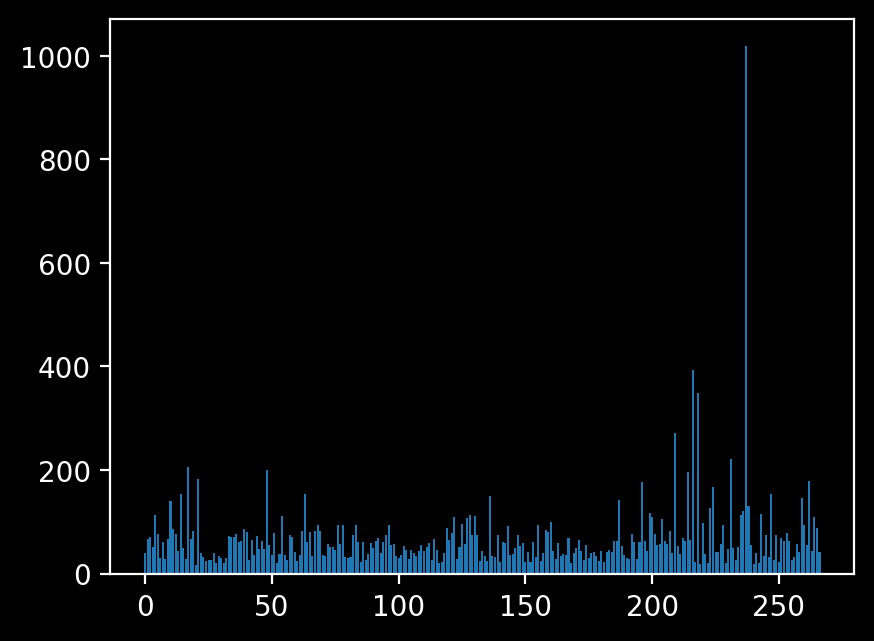

In [15]:
plt.bar(np.arange(len(djt)), [djt[x].time for x in range(len(djt))])

In [23]:
medt_dt = 0
for x in range(len(djt)):
    medt_dt += djt[x].time
medt_dt = medt_dt/len(djt)

medt_jb = 0
for x in range(len(jrb)):
    medt_jb += jrb[x].time
medt_jb = medt_jb/len(jrb)

In [24]:
long_djt = [djt[x] for x in range(len(djt)) if djt[x].time >= medt_dt]
long_jrb = [jrb[x] for x in range(len(jrb)) if jrb[x].time >= medt_jb]

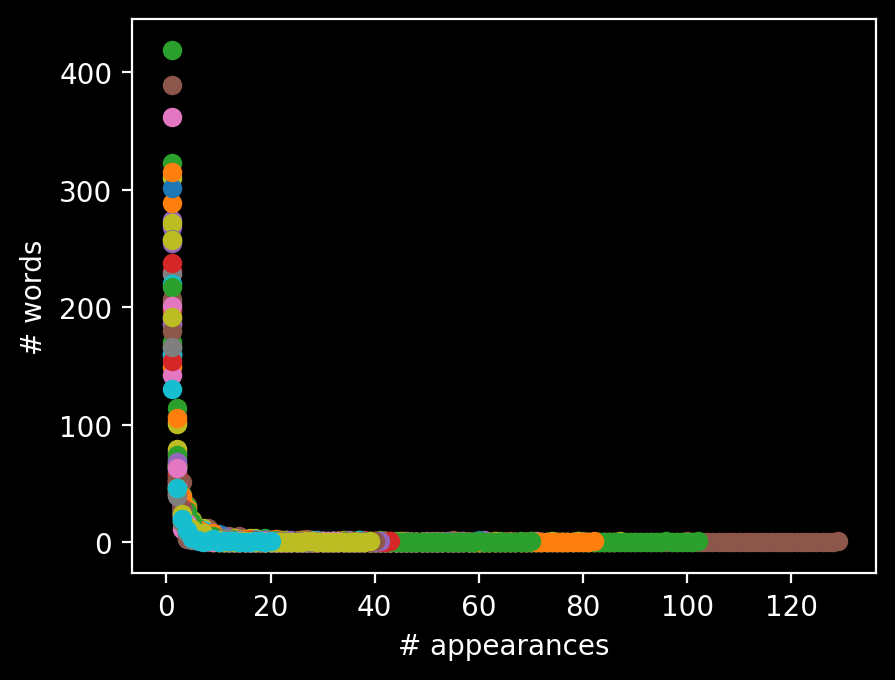

In [25]:
wordfreq(long_jrb)

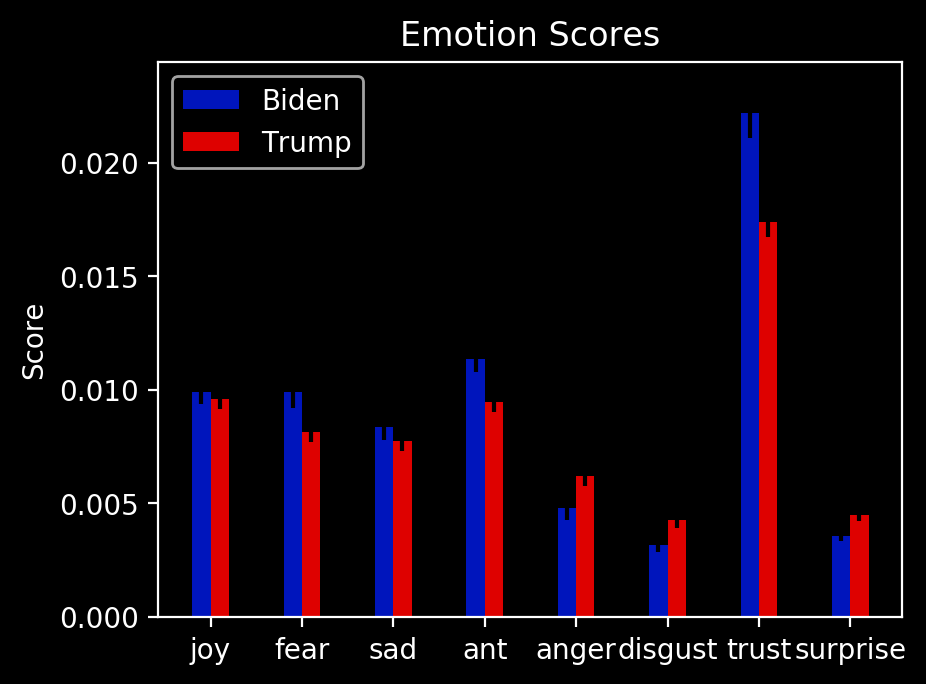

<Figure size 3000x2000 with 0 Axes>

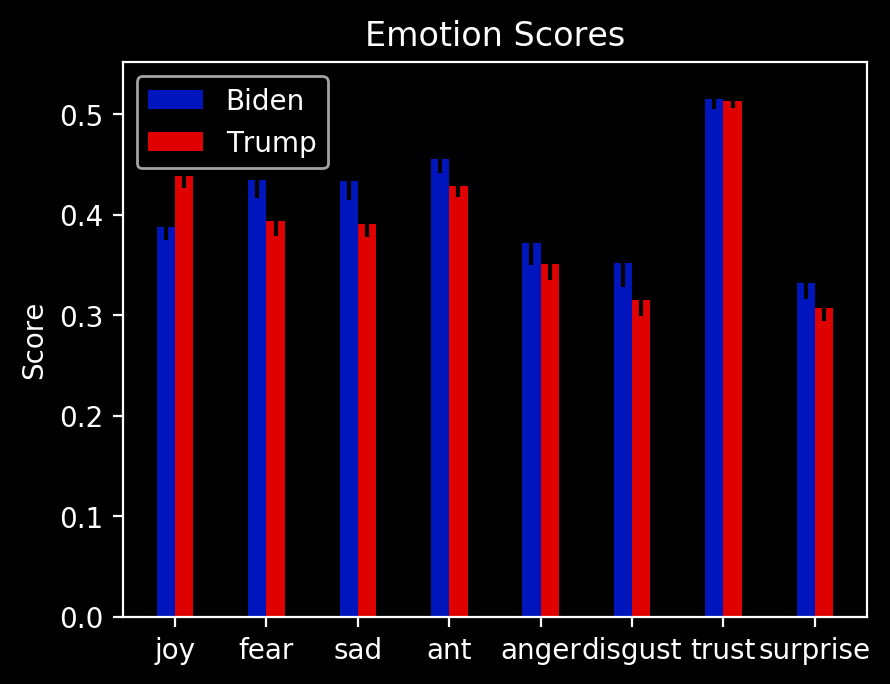

<Figure size 3000x2000 with 0 Axes>

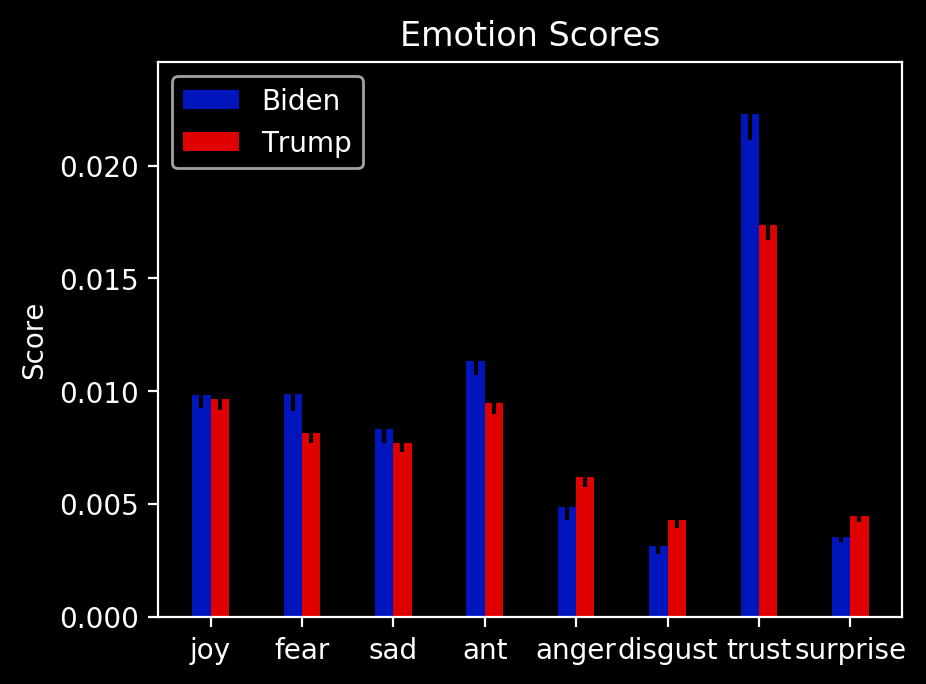

<Figure size 3000x2000 with 0 Axes>

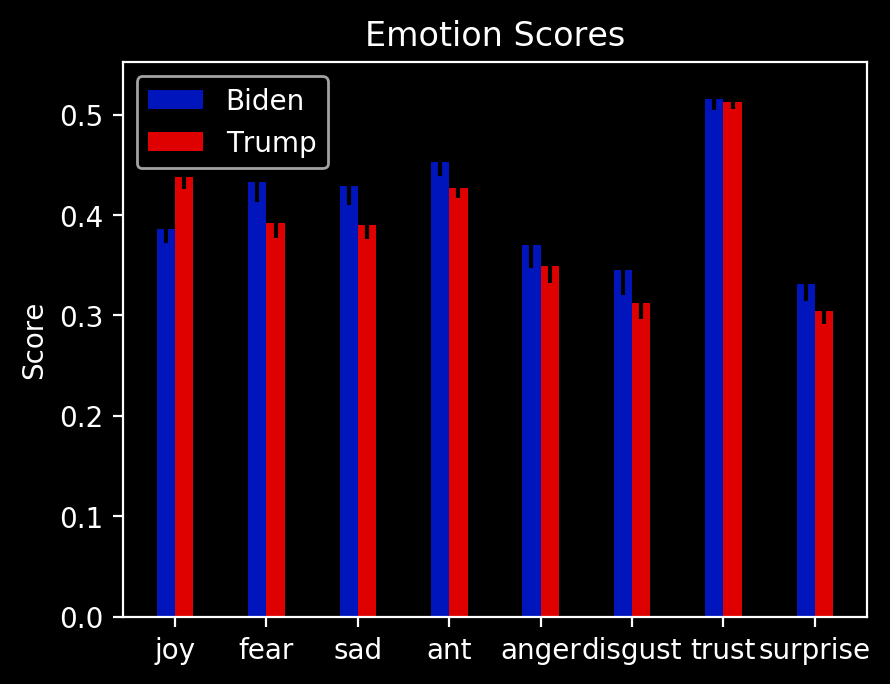

<Figure size 3000x2000 with 0 Axes>

In [26]:
tablemaker(emot_glb,'Emotion Scores',alsoticks=('joy','fear','sad','ant','anger','disgust','trust','surprise'))
tablemaker(emot_loc,'Emotion Scores',alsoticks=('joy','fear','sad','ant','anger','disgust','trust','surprise'))

tablemaker(emot_glb,'Emotion Scores',alsoticks=('joy','fear','sad','ant','anger','disgust','trust','surprise'),time='true')
tablemaker(emot_loc,'Emotion Scores',alsoticks=('joy','fear','sad','ant','anger','disgust','trust','surprise'),time='true')


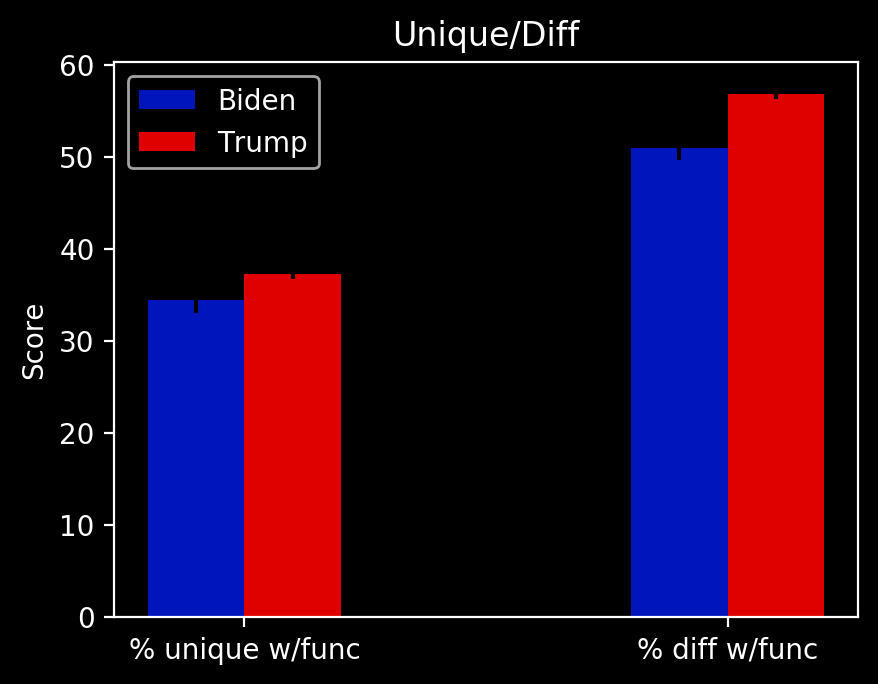

<Figure size 3000x2000 with 0 Axes>

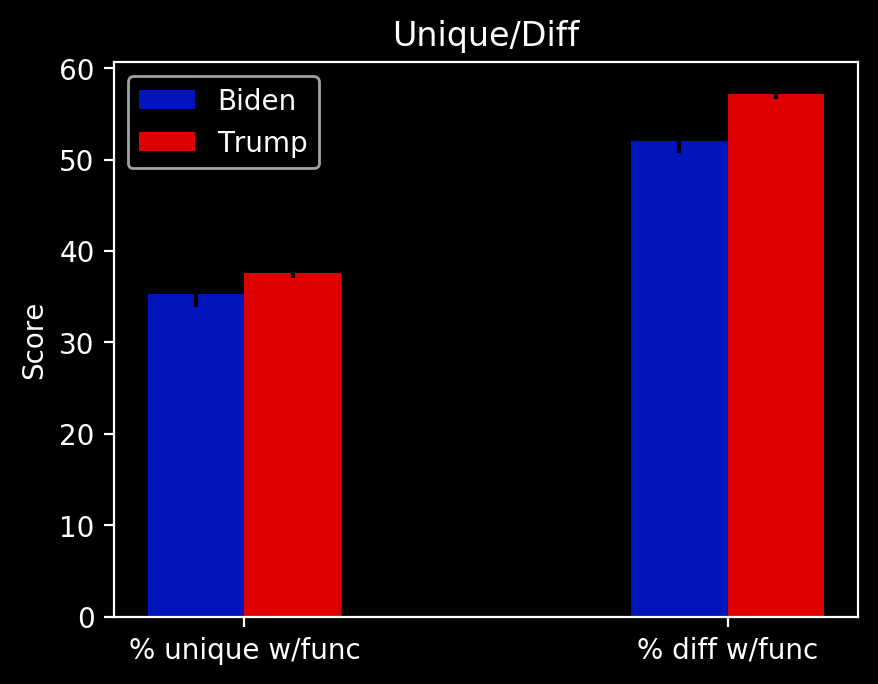

<Figure size 3000x2000 with 0 Axes>

In [27]:
tablemaker(['% unique w/func','% diff w/func'], 'Unique/Diff')
tablemaker(['% unique w/func','% diff w/func'], 'Unique/Diff',time='True')

In [ ]:

dir(djt[0])

In [28]:
sum([len(djt[i].rare_nonfunc) for i in range(len(djt))]) / len(djt)

46.53558052434457

In [29]:
djt[0].words_tok

['No',
 '.',
 'Not',
 'at',
 'all',
 '.',
 'If',
 'you',
 'look',
 'at',
 'what',
 'happened',
 'in',
 'Minnesota',
 ',',
 'they',
 'were',
 'getting',
 'decimated',
 ',',
 'and',
 'after',
 'three',
 'days',
 'of',
 'watching',
 'it',
 ',',
 'I',
 'demanded',
 'that',
 'the',
 'National',
 'Guard',
 'be',
 'utilized',
 ',',
 'and',
 'in',
 'one',
 'day',
 ',',
 'it',
 'was',
 'over',
 '.',
 'In',
 'fact',
 ',',
 'they',
 'got',
 'there',
 'at',
 'a',
 'certain',
 'time',
 'in',
 'the',
 'late',
 'afternoon',
 ',',
 'and',
 'by',
 'the',
 'time',
 'they',
 'finished',
 ',',
 'it',
 'was',
 ',',
 'I',
 'always',
 'say',
 'a',
 'somewhat',
 'sarcastically',
 ',',
 'but',
 'the',
 'safest',
 'place',
 'on',
 'earth',
 'to…',
 'and',
 'Minnesota',
 'was',
 'really',
 ',',
 'really',
 'having',
 'a',
 'hard',
 'time',
 ',',
 'and',
 'we',
 'took',
 'care',
 'of',
 'it',
 '.',
 'The',
 'governor',
 'is',
 'a',
 'nice',
 'man',
 ',',
 'and',
 'he',
 'was',
 'not',
 'using',
 'enough',
 ',',
 

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


lemmatizer  = WordNetLemmatizer()

text = "All models are wrong, but some are useful."

tokens = word_tokenize(text.lower())

lemmas = [lemmatizer.lemmatize(token) for token in tokens]

In [ ]:
import re

text = """
I liked this show from the first episode I saw, which was the "Rhapsody in Blue" episode (for those that don't know what that is, the Zan going insane and becoming pau lvl 10 ep). Best visuals and special effects I've seen on a television series, nothing like it anywhere.
"""
s = re.sub(r'[^a-zA-Z\']', ' ', text)
s

In [2]:
import str


ModuleNotFoundError: No module named 'scraper'